In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score, recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

import time
import warnings
warnings.filterwarnings("ignore")

# NOTES
**1. I test with different Scale Method + Sampling technique for Model ML, it will take a long time if use loop to test so I split to small case to test**

**2. You will see that it has the same name like X_train_1, y_train_1,.. for each cases, but actually I always reset from step 1 to certain I take a True test for each case. For Example, after test with non scale case, next case is minmaxscale, I reset from step 1( u will see later) and scale data, sampling,.., testing with model**

In [3]:
data = pd.read_csv('/kaggle/input/data-final/train.csv')

# Data Problems
**1. Imbalance** - USE SMOTE

**2. Code Gender contain "XNA" value**

**3. DAY_BIRTH negative**

**4. DAY_EMPLOYED contain value > 1000 years**

**5. NaN value**

# Preprocessing

**1. Drop "XNA" value**

In [6]:
data = data[data['CODE_GENDER'] != "XNA"]

**2. DAY_BIRTH**

In [7]:
data['DAYS_BIRTH'] = abs(data['DAYS_BIRTH'])

**3. Fill NaN DAY_EMPLOYED contain value > 1000 years**

In [8]:
data.replace(max(data['DAYS_EMPLOYED'].values), np.nan, inplace=True)

**4. Handling NaN value**

In [9]:
def missing_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns['Data Type'] = df.dtypes[mis_val_table_ren_columns.index]
        
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
      
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        return mis_val_table_ren_columns

In [10]:
missing_values = missing_values_table(data)
missing_values

Your selected dataframe has 46 columns.
There are 21 columns that have missing values.


,Missing Values,% of Total Values,Data Type
OWN_CAR_AGE,104018,66.0,float64
EXT_SOURCE_1,88686,56.3,float64
OCCUPATION_TYPE,49360,31.3,object
EXT_SOURCE_3,31143,19.8,float64
DAYS_EMPLOYED,28237,17.9,float64
AMT_REQ_CREDIT_BUREAU_YEAR,21118,13.4,float64
AMT_REQ_CREDIT_BUREAU_QRT,21118,13.4,float64
AMT_REQ_CREDIT_BUREAU_MON,21118,13.4,float64
AMT_REQ_CREDIT_BUREAU_WEEK,21118,13.4,float64
AMT_REQ_CREDIT_BUREAU_DAY,21118,13.4,float64


In [21]:
missing_values.iloc[:, 0]

OWN_CAR_AGE                   104018
EXT_SOURCE_1                   88686
OCCUPATION_TYPE                49360
EXT_SOURCE_3                   31143
DAYS_EMPLOYED                  28237
AMT_REQ_CREDIT_BUREAU_YEAR     21118
AMT_REQ_CREDIT_BUREAU_QRT      21118
AMT_REQ_CREDIT_BUREAU_MON      21118
AMT_REQ_CREDIT_BUREAU_WEEK     21118
AMT_REQ_CREDIT_BUREAU_DAY      21118
AMT_REQ_CREDIT_BUREAU_HOUR     21118
NAME_TYPE_SUITE                  646
DEF_60_CNT_SOCIAL_CIRCLE         523
OBS_30_CNT_SOCIAL_CIRCLE         523
OBS_60_CNT_SOCIAL_CIRCLE         523
DEF_30_CNT_SOCIAL_CIRCLE         523
EXT_SOURCE_2                     338
AMT_GOODS_PRICE                  133
AMT_ANNUITY                        8
DAYS_LAST_PHONE_CHANGE             1
CNT_FAM_MEMBERS                    1
Name: Missing Values, dtype: int64

**Drop columns which have percentage NaN value >= 50%**

**Fill NaN value for categorical features has % NaN < 2% = mode**

**Fill NaN value for categorical features has % NaN > 2% = "Missing"**

**Fill NaN value for numerical features = mean**

In [12]:
data = data.drop(['OWN_CAR_AGE', 'EXT_SOURCE_1'], axis=1)

In [24]:
nan_nums = ['EXT_SOURCE_3','DAYS_EMPLOYED', 'AMT_REQ_CREDIT_BUREAU_YEAR',    
'AMT_REQ_CREDIT_BUREAU_QRT',   'AMT_REQ_CREDIT_BUREAU_MON',     
'AMT_REQ_CREDIT_BUREAU_WEEK',  'AMT_REQ_CREDIT_BUREAU_DAY',      
'AMT_REQ_CREDIT_BUREAU_HOUR',  'DEF_60_CNT_SOCIAL_CIRCLE',  
'OBS_30_CNT_SOCIAL_CIRCLE',    'OBS_60_CNT_SOCIAL_CIRCLE',        
'DEF_30_CNT_SOCIAL_CIRCLE',    'EXT_SOURCE_2',                     
'AMT_GOODS_PRICE',   'AMT_ANNUITY',  'DAYS_LAST_PHONE_CHANGE',            
'CNT_FAM_MEMBERS']
for nan_num in nan_nums:
    data[nan_num] = data[nan_num].fillna(data[nan_num].mean())

In [31]:
data['NAME_TYPE_SUITE'].fillna('Missing', inplace=True)
data['OCCUPATION_TYPE'].fillna('Missing', inplace=True)

# MODEL

In [2]:
names = [
    "Logistic Regression",
    "KNN Classifier",
    "Decision Tree",
    "Random Forest",
    "XGBoost",
    "AdaBoost",
]

models = [
    LogisticRegression(),
    KNeighborsClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    XGBClassifier(),
    AdaBoostClassifier(),
]

In [3]:
def score(X_train, X_test, y_train, y_test, names = names, models = models):
    score_df, score_test = pd.DataFrame(), []
    x = time.time()
    for model in models:
        model.fit(X_train, y_train)
        y_test_pred = model.predict(X_test)
        score_test.append({
            'Classifier': model.__class__.__name__,
            'Accuracy': accuracy_score(y_test, y_test_pred),
            'F1 Score': f1_score(y_test, y_test_pred),
            'Recall': recall_score(y_test, y_test_pred)
        })

    score_df = pd.DataFrame(score_test)
    score_df.sort_values(by='Accuracy', ascending=False, inplace=True)
    return score_df

# Predict Using All Orginal Features

**Step:**
1. Encoding Categorical features by One Hot Encoder
2. Split train test with different size 70:30, 80:20
3. Scale data by MinMax Scaler, Standardlize
4. Data Imbalance Handing
5. Use different Machine Learning algorithms

**Step 1**

In [15]:
data_encode = pd.get_dummies(data)

**Step 2**

In [16]:
data_encode.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA
0,100002,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,9461,-637.0,...,False,False,False,False,False,False,False,False,False,False
1,100003,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,16765,-1188.0,...,False,False,False,False,False,False,False,False,False,False
2,100004,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,19046,-225.0,...,False,False,False,False,False,False,False,False,False,False
3,100006,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,19005,-3039.0,...,False,False,False,False,False,False,False,False,False,False
4,100007,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,19932,-3038.0,...,False,False,False,False,False,False,False,False,False,False


In [17]:
# 70 - 30
X_1 = data_encode.drop(['SK_ID_CURR','TARGET'], axis=1)
y_1 = data_encode['TARGET']

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, test_size=0.3, stratify=y_1, random_state=42)

print("X=",X_train_1.shape, X_test_1.shape)
print("y=",y_train_1.shape, y_test_1.shape)

X= (110255, 155) (47253, 155)
y= (110255,) (47253,)


In [34]:
# 80 - 20
X_2 = data_encode.drop(['SK_ID_CURR','TARGET'], axis=1)
y_2 = data_encode['TARGET']

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.2, stratify=y_2, random_state=42)

print("X=",X_train_2.shape, X_test_2.shape)
print("y=",y_train_2.shape, y_test_2.shape)

X= (126006, 155) (31502, 155)
y= (126006,) (31502,)


**Step 3**

In [46]:
scaler1 = MinMaxScaler()

In [47]:
cols = X_train_1.columns
X_train_1[cols] = scaler1.fit_transform(X_train_1[cols])
X_test_1[cols] = scaler1.transform(X_test_1[cols])

In [48]:
cols = X_train_2.columns
X_train_2[cols] = scaler1.fit_transform(X_train_2[cols])
X_test_2[cols] = scaler1.transform(X_test_2[cols])

In [35]:
scaler2 = StandardScaler()

In [36]:
cols = X_train_1.columns
X_train_1[cols] = scaler2.fit_transform(X_train_1[cols])
X_test_1[cols] = scaler2.transform(X_test_1[cols])

In [37]:
cols = X_train_2.columns
X_train_2[cols] = scaler2.fit_transform(X_train_2[cols])
X_test_2[cols] = scaler2.transform(X_test_2[cols])

**Step 4**

In [12]:
sm = SMOTE(random_state=42)

In [13]:
# minmax For 70-30
X_train_1,y_train_1 = sm.fit_resample(X_train_1,y_train_1)

In [53]:
y_train_1.value_counts(normalize=True)

TARGET
0    0.5
1    0.5
Name: proportion, dtype: float64

In [54]:
# minmax For 80-20
X_train_2,y_train_2 = sm.fit_resample(X_train_2,y_train_2)

In [55]:
y_train_2.value_counts(normalize=True)

TARGET
0    0.5
1    0.5
Name: proportion, dtype: float64

In [39]:
# standard For 70-30
X_train_1,y_train_1 = sm.fit_resample(X_train_1,y_train_1)

In [40]:
# standard For 80-20
X_train_2,y_train_2 = sm.fit_resample(X_train_2,y_train_2)

**Step 5**

In [29]:
# no scale&sampling 70-30
score(X_train_1, X_test_1, y_train_1, y_test_1, names = names, models = models)

,Classifier,Accuracy,F1 Score,Recall
3,RandomForestClassifier,0.918460,0.000519,0.000259
0,LogisticRegression,0.918418,0.000000,0.000000
5,AdaBoostClassifier,0.918354,0.035982,0.018682
4,XGBClassifier,0.917529,0.059831,0.032174
1,KNeighborsClassifier,0.912916,0.028335,0.015568
2,DecisionTreeClassifier,0.853829,0.156757,0.166580


In [30]:
# no scale&sampling 80-20
score(X_train_1, X_test_1, y_train_1, y_test_1, names = names, models = models)

,Classifier,Accuracy,F1 Score,Recall
3,RandomForestClassifier,0.918439,0.000000,0.000000
0,LogisticRegression,0.918418,0.000000,0.000000
5,AdaBoostClassifier,0.918354,0.035982,0.018682
4,XGBClassifier,0.917529,0.059831,0.032174
1,KNeighborsClassifier,0.912916,0.028335,0.015568
2,DecisionTreeClassifier,0.853195,0.155363,0.165542


In [63]:
# minmax 70-30
score(X_train_1, X_test_1, y_train_1, y_test_1, names = names, models = models)

,Classifier,Accuracy,F1 Score,Recall
4,XGBClassifier,0.917571,0.068850,0.037364
3,RandomForestClassifier,0.917444,0.015645,0.008044
5,AdaBoostClassifier,0.859840,0.186264,0.196679
2,DecisionTreeClassifier,0.838889,0.147003,0.170213
0,LogisticRegression,0.691977,0.257436,0.654645
1,KNeighborsClassifier,0.650879,0.164667,0.421899


In [64]:
# minmax 80-20
score(X_train_2, X_test_2, y_train_2, y_test_2, names = names, models = models)

,Classifier,Accuracy,F1 Score,Recall
4,XGBClassifier,0.917571,0.068850,0.037364
3,RandomForestClassifier,0.917444,0.013654,0.007006
5,AdaBoostClassifier,0.859840,0.186264,0.196679
2,DecisionTreeClassifier,0.837873,0.147926,0.172548
0,LogisticRegression,0.691977,0.257436,0.654645
1,KNeighborsClassifier,0.650879,0.164667,0.421899


In [41]:
# standard 70-30
score(X_train_1, X_test_1, y_train_1, y_test_1, names = names, models = models)

,Classifier,Accuracy,F1 Score,Recall
3,RandomForestClassifier,0.917677,0.014192,0.007265
4,XGBClassifier,0.916725,0.061979,0.033731
5,AdaBoostClassifier,0.862421,0.190512,0.198495
2,DecisionTreeClassifier,0.839142,0.143549,0.165283
0,LogisticRegression,0.690559,0.256483,0.654385
1,KNeighborsClassifier,0.626288,0.174466,0.484172


In [42]:
# standard 80-20
score(X_train_2, X_test_2, y_train_2, y_test_2, names = names, models = models)

,Classifier,Accuracy,F1 Score,Recall
3,RandomForestClassifier,0.917656,0.010679,0.005450
4,XGBClassifier,0.916862,0.054854,0.029583
5,AdaBoostClassifier,0.865564,0.181643,0.182951
2,DecisionTreeClassifier,0.842232,0.155049,0.177501
0,LogisticRegression,0.691575,0.258207,0.658233
1,KNeighborsClassifier,0.628182,0.177747,0.492799


**ROC_AUC for MinMax Scale 70-30**

In [69]:
xgb_model =  XGBClassifier()
xgb_model.fit(X_train_1, y_train_1)
xgb_pred_1 = xgb_model.predict_proba(X_test_1)[:,1]
roc = roc_auc_score(y_test_1, xgb_pred_1)
print("AUC: %.4f%% " % (roc * 100))

AUC: 73.2070% 


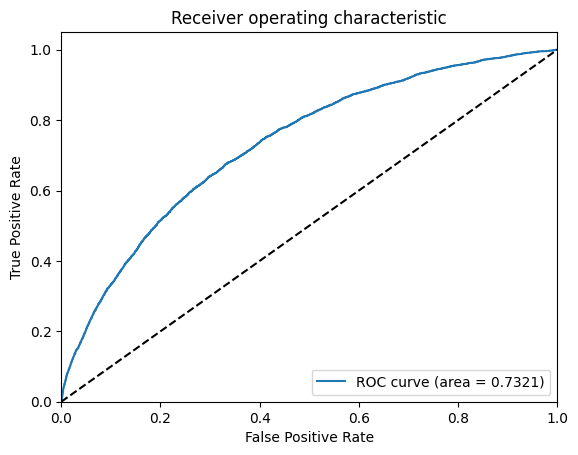

In [72]:
fpr, tpr, thresholds = roc_curve(y_test_1, xgb_pred_1)

plt.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % roc)
plt.plot([0, 1], [0, 1], 'k--')  
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

**ROC-AUC for no scale & no sampling 70-30** 

In [18]:
ranfor_model =  RandomForestClassifier()
ranfor_model.fit(X_train_1, y_train_1)
ranfor_pred_1 = ranfor_model.predict_proba(X_test_1)[:,1]
roc = roc_auc_score(y_test_1, ranfor_pred_1)
print("AUC: %.4f%% " % (roc * 100))

AUC: 71.7442% 


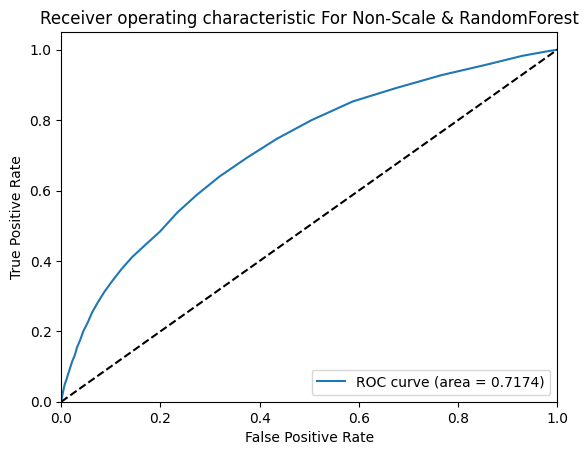

In [19]:
fpr, tpr, thresholds = roc_curve(y_test_1, ranfor_pred_1)

plt.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % roc)
plt.plot([0, 1], [0, 1], 'k--')  
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic For Non-Scale & RandomForest')
plt.legend(loc="lower right")
plt.show()

# Predict by Feature Selection using WOE

1. Calculate WoE for each features
2. Calculate IV
3. Drop feature has IV < 0.02
4. Predict ML

In [4]:
data = pd.read_csv('/kaggle/input/dataclean/data.csv')

In [3]:
def iv_woe(data, target, bins=10, show_woe=False):
    
    newDF,woeDF = pd.DataFrame(), pd.DataFrame()
    cols = data.columns
    #Run WoE and IV on all the independent variables
    for ivars in cols[~cols.isin([target])]:
        if (data[ivars].dtype.kind in 'bifc') and (len(np.unique(data[ivars]))>10):
            binned_x = pd.qcut(data[ivars], bins,  duplicates='drop')
            d0 = pd.DataFrame({'x': binned_x, 'y': data[target]})
        else:
            d0 = pd.DataFrame({'x': data[ivars], 'y': data[target]})
        d = d0.groupby("x", as_index=False).agg({"y": ["count", "sum"]})
        d.columns = ['Cutoff', 'N', 'Events']
        d['% of Events'] = np.maximum(d['Events'], 0.5) / d['Events'].sum()
        d['Non-Events'] = d['N'] - d['Events']
        d['% of Non-Events'] = np.maximum(d['Non-Events'], 0.5) / d['Non-Events'].sum()
        d['WoE'] = np.log(d['% of Events']/d['% of Non-Events'])
        d['IV'] = d['WoE'] * (d['% of Events'] - d['% of Non-Events'])
        d.insert(loc=0, column='Variable', value=ivars)
        print("Information value of " + ivars + " is " + str(round(d['IV'].sum(),6)))
        temp =pd.DataFrame({"Variable" : [ivars], "IV" : [d['IV'].sum()]}, columns = ["Variable", "IV"])
        newDF=pd.concat([newDF,temp], axis=0)
        woeDF=pd.concat([woeDF,d], axis=0)
    

        if show_woe == True:
            print(d)
            
    return newDF, woeDF

iv, woe = iv_woe(data, target='TARGET', bins=20)

Information value of SK_ID_CURR is 0.000998
Information value of NAME_CONTRACT_TYPE is 0.01585
Information value of CODE_GENDER is 0.039547
Information value of FLAG_OWN_CAR is 0.007159
Information value of FLAG_OWN_REALTY is 0.000404
Information value of CNT_CHILDREN is 0.001431
Information value of AMT_INCOME_TOTAL is 0.010765
Information value of AMT_CREDIT is 0.06031
Information value of AMT_ANNUITY is 0.032649
Information value of AMT_GOODS_PRICE is 0.107278
Information value of NAME_TYPE_SUITE is 0.001727
Information value of NAME_INCOME_TYPE is 0.057243
Information value of NAME_EDUCATION_TYPE is 0.050073
Information value of NAME_FAMILY_STATUS is 0.024653
Information value of NAME_HOUSING_TYPE is 0.015067
Information value of REGION_POPULATION_RELATIVE is 0.048776
Information value of DAYS_BIRTH is 0.089503
Information value of DAYS_EMPLOYED is 0.107336
Information value of DAYS_REGISTRATION is 0.027933
Information value of DAYS_ID_PUBLISH is 0.041378
Information value of FLAG_

**DROP IV < 0.02**

In [4]:
low_IV_cols =  ['SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
      'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'NAME_TYPE_SUITE', 'NAME_HOUSING_TYPE',
       'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'CNT_FAM_MEMBERS', 'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START',
        'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
          'OBS_60_CNT_SOCIAL_CIRCLE', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'AMT_REQ_CREDIT_BUREAU_HOUR',   
'AMT_REQ_CREDIT_BUREAU_QRT',   'AMT_REQ_CREDIT_BUREAU_MON',   'AMT_REQ_CREDIT_BUREAU_WEEK']

In [5]:
data_woe = data.drop(low_IV_cols, axis = 1)

**Step:**
1. Encoding Categorical features by One Hot Encoder
2. Split train test with different size 70:30, 80:20
3. Scale data by MinMax Scaler
4. Data Imbalance Handing
5. Use different Machine Learning algorithms

**Step 1**

In [9]:
data_encode = pd.get_dummies(data_woe)

**Step 2**

In [10]:
# 70 - 30
Xw_1 = data_encode.drop(['TARGET'], axis=1)
yw_1 = data_encode['TARGET']

X_trainw_1, X_testw_1, y_trainw_1, y_testw_1 = train_test_split(Xw_1, yw_1, test_size=0.3, stratify=yw_1, random_state=42)

print("X=",X_trainw_1.shape, X_testw_1.shape)
print("y=",y_trainw_1.shape, y_testw_1.shape)

X= (110255, 113) (47253, 113)
y= (110255,) (47253,)


In [11]:
# 80 - 20
Xw_2 = data_encode.drop(['TARGET'], axis=1)
yw_2 = data_encode['TARGET']

X_trainw_2, X_testw_2, y_trainw_2, y_testw_2 = train_test_split(Xw_2, yw_2, test_size=0.2, stratify=yw_2, random_state=42)

print("X=",X_trainw_2.shape, X_testw_2.shape)
print("y=",y_trainw_2.shape, y_testw_2.shape)

X= (110255, 113) (47253, 113)
y= (110255,) (47253,)


**Step 3**

In [100]:
scaler1 = MinMaxScaler()

In [101]:
cols = X_trainw_1.columns
X_trainw_1[cols] = scaler1.fit_transform(X_trainw_1[cols])
X_testw_1[cols] = scaler1.transform(X_testw_1[cols])

In [102]:
cols = X_trainw_2.columns
X_trainw_2[cols] = scaler1.fit_transform(X_trainw_2[cols])
X_testw_2[cols] = scaler1.transform(X_testw_2[cols])

In [12]:
scaler2 = StandardScaler()

In [13]:
cols = X_trainw_1.columns
X_trainw_1[cols] = scaler2.fit_transform(X_trainw_1[cols])
X_testw_1[cols] = scaler2.transform(X_testw_1[cols])

In [14]:
cols = X_trainw_2.columns
X_trainw_2[cols] = scaler2.fit_transform(X_trainw_2[cols])
X_testw_2[cols] = scaler2.transform(X_testw_2[cols])

**Step 4**

In [15]:
sm = SMOTE(random_state=42)

In [104]:
# minmax scaler + 70-30
X_trainw_1,y_trainw_1 = sm.fit_resample(X_trainw_1,y_trainw_1)

In [105]:
# minmax scaler + 80-20
X_trainw_2,y_trainw_2 = sm.fit_resample(X_trainw_2,y_trainw_2)

In [16]:
# standard scaler + 70-30
X_trainw_1,y_trainw_1 = sm.fit_resample(X_trainw_1,y_trainw_1)

In [17]:
# standard scaler + 80-20
X_trainw_2,y_trainw_2 = sm.fit_resample(X_trainw_2,y_trainw_2)

**Step 5**

In [106]:
# minmax 70-30
score(X_trainw_1, X_testw_1, y_trainw_1, y_testw_1, names = names, models = models)

,Classifier,Accuracy,F1 Score,Recall
4,XGBClassifier,0.893255,0.175278,0.139076
3,RandomForestClassifier,0.886589,0.180706,0.153347
2,DecisionTreeClassifier,0.792839,0.172737,0.265179
5,AdaBoostClassifier,0.774215,0.227052,0.406591
0,LogisticRegression,0.682962,0.255824,0.668137
1,KNeighborsClassifier,0.682369,0.177634,0.420602


In [107]:
# minmax 80-20
score(X_trainw_2, X_testw_2, y_trainw_2, y_testw_2, names = names, models = models)

,Classifier,Accuracy,F1 Score,Recall
4,XGBClassifier,0.893255,0.175278,0.139076
3,RandomForestClassifier,0.887012,0.177223,0.149196
2,DecisionTreeClassifier,0.791844,0.168836,0.259211
5,AdaBoostClassifier,0.774215,0.227052,0.406591
0,LogisticRegression,0.682962,0.255824,0.668137
1,KNeighborsClassifier,0.682369,0.177634,0.420602


In [109]:
xgb_model =  XGBClassifier()
xgb_model.fit(X_train_1, y_train_1)
xgb_pred_1 = xgb_model.predict_proba(X_test_1)[:,1]
roc = roc_auc_score(y_test_1, xgb_pred_1)
print("AUC: %.4f%% " % (roc * 100))

AUC: 68.9716% 


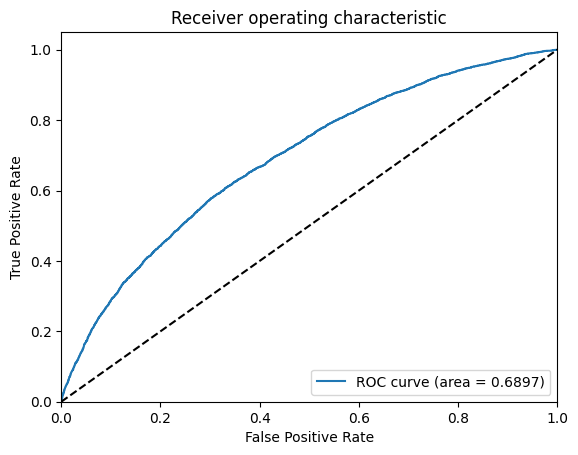

In [110]:
fpr, tpr, thresholds = roc_curve(y_test_1, xgb_pred_1)

plt.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % roc)
plt.plot([0, 1], [0, 1], 'k--')  
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [18]:
# standard 70-30
score(X_trainw_1, X_testw_1, y_trainw_1, y_testw_1, names = names, models = models)

,Classifier,Accuracy,F1 Score,Recall
4,XGBClassifier,0.900430,0.173837,0.128438
3,RandomForestClassifier,0.895880,0.152017,0.114427
2,DecisionTreeClassifier,0.798658,0.165731,0.245200
5,AdaBoostClassifier,0.781580,0.231783,0.403996
1,KNeighborsClassifier,0.700421,0.178410,0.398806
0,LogisticRegression,0.685840,0.256449,0.664245


In [19]:
# standard 80-20
score(X_trainw_2, X_testw_2, y_trainw_2, y_testw_2, names = names, models = models)

,Classifier,Accuracy,F1 Score,Recall
4,XGBClassifier,0.900430,0.173837,0.128438
3,RandomForestClassifier,0.895943,0.152388,0.114686
2,DecisionTreeClassifier,0.798828,0.170072,0.252724
5,AdaBoostClassifier,0.781580,0.231783,0.403996
1,KNeighborsClassifier,0.700421,0.178410,0.398806
0,LogisticRegression,0.685840,0.256449,0.664245


In [11]:
# no scale 70-30
score(X_trainw_1, X_testw_1, y_trainw_1, y_testw_1, names = names, models = models)

,Classifier,Accuracy,F1 Score,Recall
3,RandomForestClassifier,0.918630,0.005175,0.002595
0,LogisticRegression,0.918397,0.000000,0.000000
5,AdaBoostClassifier,0.918206,0.032056,0.016606
4,XGBClassifier,0.917741,0.055866,0.029839
1,KNeighborsClassifier,0.912323,0.042966,0.024131
2,DecisionTreeClassifier,0.854020,0.153620,0.162429


In [12]:
# no scale 80-20
score(X_trainw_2, X_testw_2, y_trainw_2, y_testw_2, names = names, models = models)

,Classifier,Accuracy,F1 Score,Recall
3,RandomForestClassifier,0.918460,0.003105,0.001557
0,LogisticRegression,0.918397,0.000000,0.000000
5,AdaBoostClassifier,0.918206,0.032056,0.016606
4,XGBClassifier,0.917741,0.055866,0.029839
1,KNeighborsClassifier,0.912323,0.042966,0.024131
2,DecisionTreeClassifier,0.853300,0.156896,0.167359
